In [1]:
import pandas as pd 
import numpy as np
from collections import Counter, OrderedDict

# import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
sns.set_palette("husl")

# import utils functions and classes
from DataLoader import TADataLoader
from TextPreprocessing import TextPreprocessor, LemmatizeCorpus
from TextPreprocessing import stem_corpus
from Wordcloud import show_wordcloud

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/camillebeguin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Load data

In [2]:
loader = TADataLoader()
df_restos, df_reviews = loader.load_restos(), loader.load_reviews()

# Basic data exploration

### Restaurant data

In [3]:
df_restos.head(2)

,resto_url,resto_name,resto_rating,research_id,resto_id,meals,price range,cuisines,special diets,features
0,https://www.tripadvisor.co.uk/Restaurant_Revie...,Mezzet Dar,5.0,504169,7221903,NaN,NaN,NaN,NaN,NaN
1,https://www.tripadvisor.co.uk/Restaurant_Revie...,4 Locos Argentine Steakhouse,5.0,2536732,14976947,"Lunch, Dinner, Brunch, Drinks",NaN,"Steakhouse, Argentinian","Vegetarian Friendly, Gluten Free Options",NaN


In [4]:
df_restos.isnull().sum()

resto_url          0
resto_name         0
resto_rating       0
research_id        0
resto_id           0
meals             94
price range       81
cuisines          57
special diets     58
features         118
dtype: int64

### Review data

In [5]:
df_reviews.head(2)

,resto_name,review_url,review_title,review_content,review_date,review_rating,review_likes,user_number_reviews,user_number_likes,research_id,resto_id,review_id,review_length
0,Mezzet Dar,https://www.tripadvisor.co.uk/ShowUserReviews-...,Fabulous lunch at Dar,Booked at Mezzet Dar not realising there are t...,2019-12-01,5,0,13,5,504169,7221903,735106834,136
1,Awesome Thai #Barnes,https://www.tripadvisor.co.uk/ShowUserReviews-...,Out of lockdown into excellent Thai food,Awesome Thai worked hard during lockdown to de...,2020-07-01,5,1,13,8,186338,3490463,759914900,843


In [6]:
df_reviews.isnull().sum()

resto_name               0
review_url               0
review_title            33
review_content           0
review_date            645
review_rating            0
review_likes             0
user_number_reviews      0
user_number_likes        0
research_id              0
resto_id                 0
review_id                0
review_length            0
dtype: int64

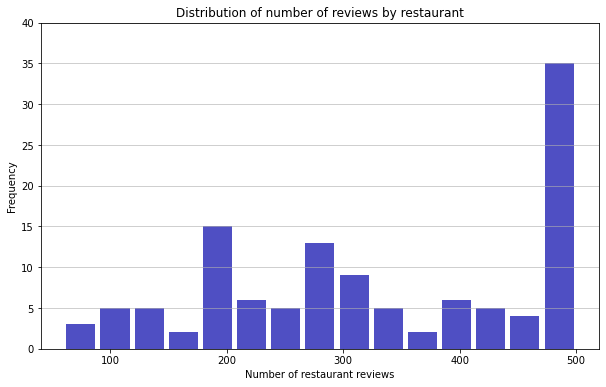

In [7]:
# show number of reviews per restaurant
n, bins, patches = plt.hist(x=df_reviews['resto_name'].value_counts(), bins=15, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of restaurant reviews')
plt.ylabel('Frequency')
plt.title('Distribution of number of reviews by restaurant')
maxfreq = n.max()

# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.show()

# Data visualization

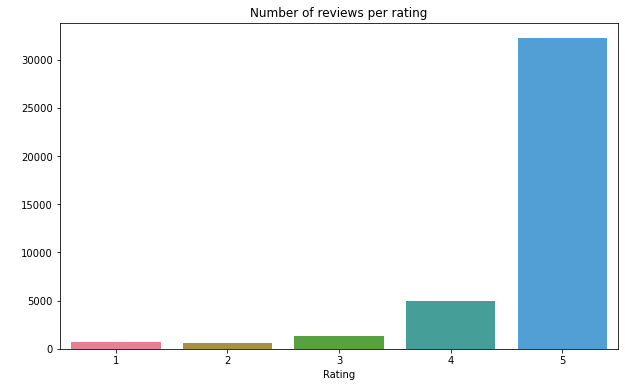

In [8]:
sns.countplot(x='review_rating', data=df_reviews)
plt.title('Number of reviews per rating')
plt.xlabel('Rating')
plt.ylabel(' ')
plt.show()

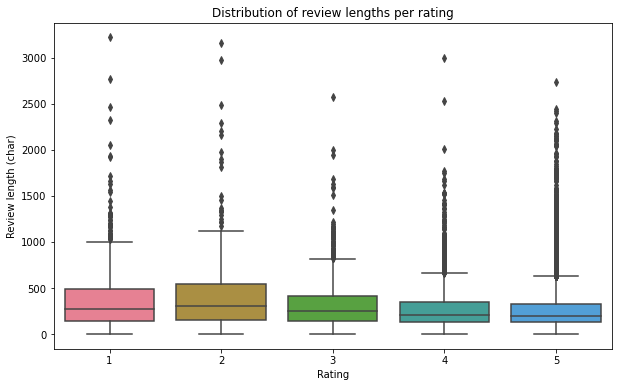

In [9]:
sns.boxplot(x='review_rating', y='review_length', data=df_reviews)
plt.xlabel('Rating')
plt.ylabel('Review length (char)')
plt.title('Distribution of review lengths per rating')
plt.show()

We notice that dissatisfied customers tend to post slightly longer reviews. 

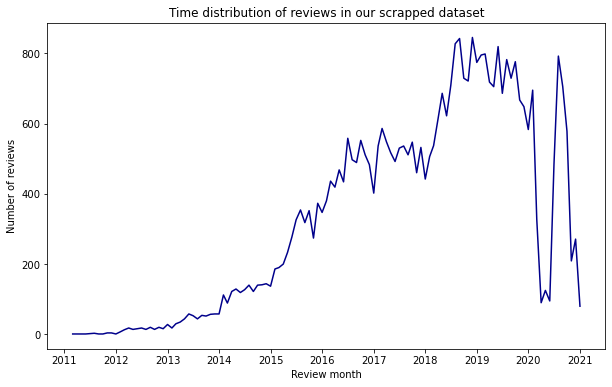

In [10]:
reviews_by_date = df_reviews['review_date'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=reviews_by_date.index, y=reviews_by_date.values, color='darkblue')
plt.title('Time distribution of reviews in our scrapped dataset')
plt.xlabel('Review month')
plt.ylabel('Number of reviews')
plt.show()

As mentioned in our business case, the restaurant has been closed since March 20th with a short reopening in November 2020. The peak in the number of reviews in November is a positive indicator to show that customers are willing to go to restaurants and bars again. The restaurant can thus be optimistic about customer visits at reopening.

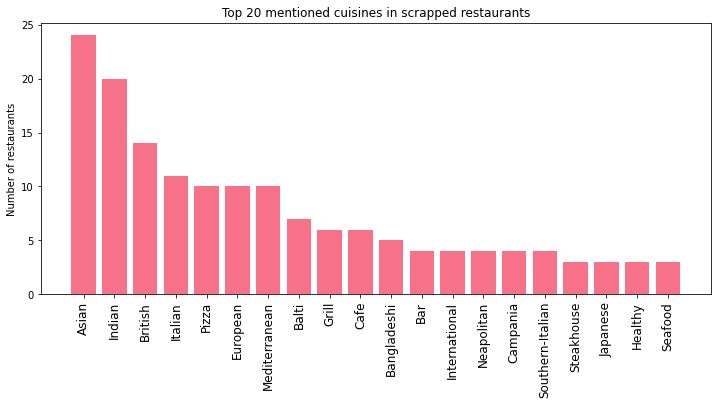

In [11]:
# Get count of cuisine mentions
cuisines = ",".join(cuisine for cuisine in df_restos['cuisines'].dropna())
cuisines = Counter([cuisine.strip() for cuisine in cuisines.split(',')])
cuisines_ordered = OrderedDict(cuisines.most_common())

# Plot number of mentions per cuisine
y_pos = np.arange(len(list(cuisines_ordered.keys())[:20]))
plt.figure(figsize=(12, 5))
plt.bar(y_pos, list(cuisines_ordered.values())[:20])
plt.xticks(y_pos, list(cuisines_ordered.keys())[:20], rotation=90, fontsize=12)
plt.ylabel('Number of restaurants')
plt.title('Top 20 mentioned cuisines in scrapped restaurants')
plt.show()

It appears that Asian cuisine is very popular in the Greater London area. Indian food is the second most common cuisine in terms of mentions, while British only comes 3rd.

# Text preprocessing

In [12]:
preprocessor = TextPreprocessor(df_reviews, column_to_clean='review_content')
preprocessor.transform()
corpus = preprocessor.corpus

In [13]:
print(f"An example of preprocessed review: \n Initial review: {df_reviews['review_content'][0]}\n\nPreprocessed review: {corpus[0]}")

An example of preprocessed review: 
 Initial review: Booked at Mezzet Dar not realising there are two different restaurants, so arrived at Mezzet and were redirected two doors away to Dar. 

Preprocessed review: ['booked', 'mezzet', 'dar', 'realising', 'two', 'different', 'restaurants', 'arrived', 'mezzet', 'redirected', 'two', 'doors', 'away', 'dar']


# Wordclouds

Wordcloud of reviews for all ratings


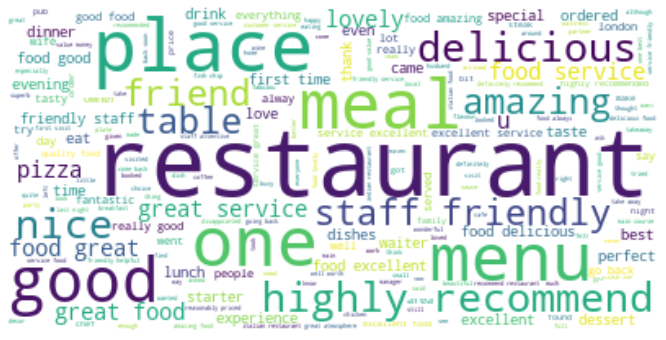

In [14]:
show_wordcloud(corpus)

Wordcloud of reviews with rating 5:


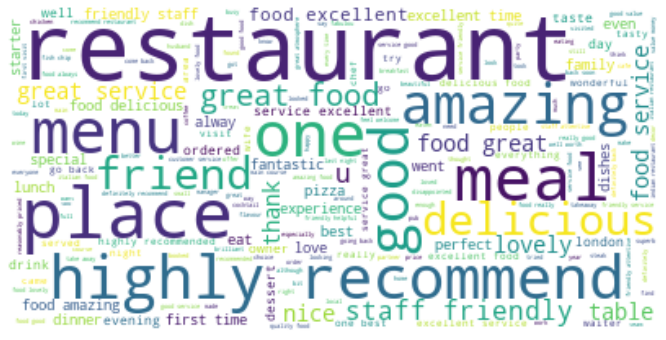

In [15]:
show_wordcloud(corpus, df_reviews['review_rating'], 5)

Wordcloud of reviews with rating 1:


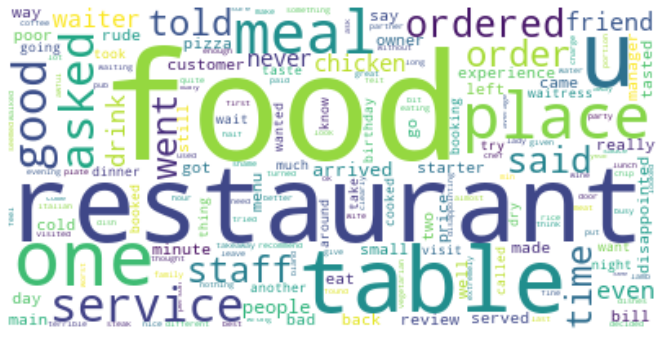

In [16]:
show_wordcloud(corpus, df_reviews['review_rating'], 1)

# Stemming/Lemmatization

In [17]:
porter_stemmed = stem_corpus(corpus, stemmer_type="Porter")
lancaster_stemmed = stem_corpus(corpus, stemmer_type="Lancaster")

In [18]:
print(f"An example of preprocessed review: \n Initial review: {df_reviews['review_content'][0]}\n\nPreprocessed review: {porter_stemmed[0]}")

An example of preprocessed review: 
 Initial review: Booked at Mezzet Dar not realising there are two different restaurants, so arrived at Mezzet and were redirected two doors away to Dar. 

Preprocessed review: ['book', 'mezzet', 'dar', 'real', 'two', 'diff', 'resta', 'ar', 'mezzet', 'redirect', 'two', 'door', 'away', 'dar']


We notice that both stemmers produce the same results.

In [20]:
lemmatizer = LemmatizeCorpus(corpus)
lemmatized_corpus = lemmatizer.lemmatize_corpus()

In [25]:
print(f"An example of preprocessed review: \n Initial review: {df_reviews['review_content'][4]}\n\nPreprocessed review: {lemmatized_corpus[4]}")

An example of preprocessed review: 
 Initial review: every time we visit this restaurant we are never disappointed 

Preprocessed review: ['ever', 'tim', 'visit', 'resta', 'nev', 'disappoint']
